In [225]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation
import random
import math
import IPython.display as IDisplay

# Test dataset

- circle
- moon

In [2]:
circle = pd.read_csv('circle.txt', names=['x','y'])
moon = pd.read_csv('moon.txt', names=['x','y'])
circle.shape, moon.shape

((1500, 2), (1500, 2))

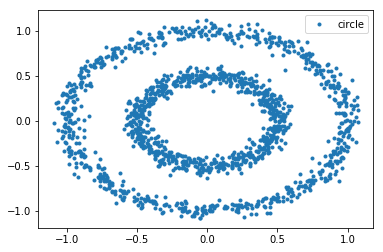

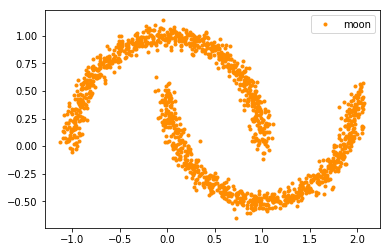

In [3]:
plt.plot(circle['x'], circle['y'],'.',label='circle')
plt.legend()
plt.show()
plt.plot(moon['x'], moon['y'],'.',c='darkorange',label='moon')
plt.legend()
plt.show()

### some common function

In [296]:
# tool and common function

def showClustering(
    datas, 
    C,
    u=None,
    title='',
    k=None, 
    color_k = ['blue', 'darkorange', 'green', 'deeppink']
):
    if k == None:
        k = len(C[0])
    
    frame = []
    
    plt.figure(figsize=(10,10))
    
    __showClustering(datas, C, u, k, color_k)
    
    plt.title(title)
    plt.legend()
    plt.show()

def __showClustering(datas, C, u, k, color_k = ['blue', 'darkorange', 'green', 'deeppink']):
    frame = []
    for i in range(k):
        if type(u) != type(None):
            l, = plt.plot(u[i][0],u[i][1],'o',
                     c=color_k[i],
                     markersize=150.0, 
                     alpha=0.3
                    )
            frame.append(l)
            l, = plt.plot(u[i][0],u[i][1],'*',
                     c=color_k[i],
                     #markersize=150.0, 
                     alpha=0.3,
                     label='clustering {} mean'.format(i+1)
                    )
            frame.append(l)
        clustering_datas = datas[C[:,i]==1,:]
        l, = plt.plot(clustering_datas[:,0],clustering_datas[:,1],
                     '.', c=color_k[i], 
                     label='clustering '+str(i+1)
                    )
        frame.append(l)

    return frame
    

def ReorderByCluster(c):
    new_order = np.array([])
    for i in range(c.shape[1]):
        new_order = np.append(new_order, np.where(c[:,i]==1)[0])
    new_order = new_order.astype('int32')
    return new_order
    
def ReorderGram(gram, c):
    new_order = ReorderByCluster(c)
    return gram[new_order,:][:,new_order]

def showGram(gram):
    plt.imshow(gram, cmap='gray')
    plt.show()

# K-means and Kernel K-means

In [177]:
# core function
def Euclidean(x,y):
    if len(x.shape)==1:
        x = x[None,:]
    if len(y.shape)==1:
        y = y[None,:]
    return np.matmul(x**2, np.ones((x.shape[1],y.shape[0]))) \
    + np.matmul(np.ones((x.shape[0],x.shape[1])), (y**2).T) \
    - 2*np.dot(x,y.T)

def RBFkernel(gamma=1):
    return lambda u,v:np.exp(-1*gamma*Euclidean(u,v));

def KernelTrick(gram_m, c):
    return (
        np.matmul(
        gram_m * np.eye(gram_m.shape[0]), 
        np.ones((gram_m.shape[0], c.shape[1])) 
    ) \
    - 2*( np.matmul(gram_m, c) / np.sum(c, axis=0) ) \
    + (np.matmul(
        np.ones((gram_m.shape[0], c.shape[1])), 
        np.matmul(np.matmul(c.T, gram_m), c)*np.eye(c.shape[1])
    ) / (np.sum(c,axis=0)**2) )
    )**2

def RandomCluster(n,k):
    c = np.zeros((n,k))
    c[np.arange(n),np.random.randint(k,size=n)] = 1             
    return c

def RandomMean(k,dim):
    return -1 + 2*np.random.random((k,dim))

def GetMeanFromCluster(datas, c):
    return np.matmul(c.T, datas) / np.sum(c, axis=0)[:,None]

def GetCluster(w):
    new_c = np.zeros(w.shape)
    new_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1
    return new_c

def kmeans(datas, k, initial_u=None, initial_c=None,isKernel=False, converge_count = 1):
    if isKernel:
        gram_matrix = datas
        c = initial_c if type(initial_c)!=type(None) \
            else RandomCluster(datas.shape[0], k)
    else:
        u = initial_u if type(initial_u)!=type(None) \
            else GetMeanFromCluster(datas, RandomCluster(datas.shape[0], k)) #RandomMean(k,datas.shape[1])
        c = np.zeros((datas.shape[0],k))
    
    while(1):
        # E-step
        if not isKernel:
            w = Euclidean(datas, u)
        else:
            w = KernelTrick(gram_matrix, c)

        # M-step
        update_c = np.zeros(w.shape)
        update_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1
    
        delta_c = np.count_nonzero(np.abs(update_c - c))
        if not isKernel:
            u = GetMeanFromCluster(datas, update_c)
        else:
            u = None
        
        yield update_c, u
        
        if delta_c == 0:
            converge_count-=1
            if converge_count == 0:
                break
        
        c = update_c
    
    return

In [272]:
# iter function
def runKmeans(launcher):
    iter_count = 0
    all_c = []
    all_u = []
    for new_c, new_u in launcher:
        IDisplay.clear_output(wait=True)
        iter_count += 1
        showClustering(data_source, new_c, new_u, title='iter [{}]'.format(iter_count))
        all_c.append(new_c)
        all_u.append(new_u)

    print('use {} counts to converge'.format(iter_count))
    
    return all_c, all_u

# K-means

In [294]:
# initial setting
data_source = np.array(moon)
k = 4

launcher = kmeans(data_source, k, initial_u=RandomMean(k, data_source.shape[1]))

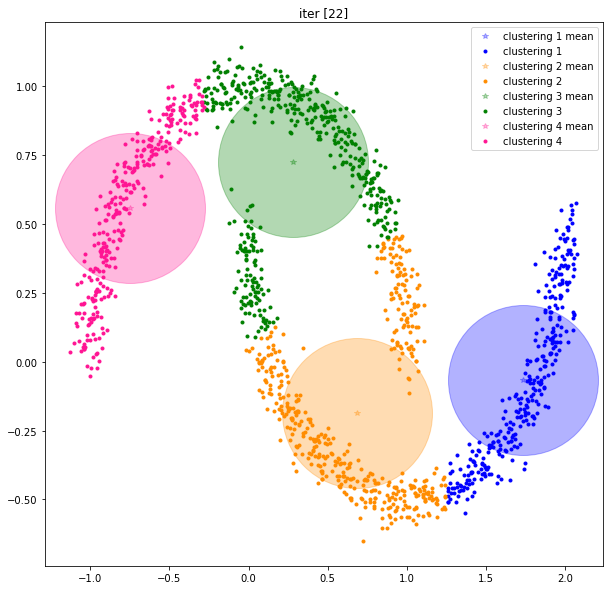

use 22 counts to converge


In [295]:
all_kmean_c, all_kmean_u = runKmeans(launcher)

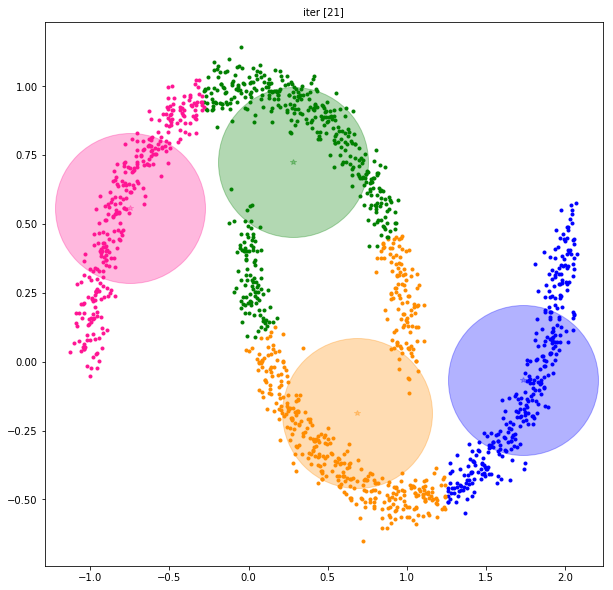

In [307]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
#title = plt.title('')
#legend = plt.legend()

frames = []

for idx, (c, u) in enumerate(zip(all_kmean_c, all_kmean_u)):
    kk = c.shape[1]
    f = __showClustering(data_source, c, u, kk)
    
    #legend = fig.legend(f)
    #f += [legend]
    
    title = plt.text(0.5, 1.01, 'iter [{}]'.format(idx),
                     horizontalalignment='center', 
                     verticalalignment='bottom',
                     transform=ax.transAxes
                    )
    
    f += [title]
    frames.append(f)
    
def anim_frame(i):
    global title
    global legend
    c = all_kmean_c[i]
    u = all_kmean_u[i]
    kk = c.shape[1]
    
    f = __showClustering(data_source, c, u, kk)
    #title.remove()
    title = plt.title('iter [{}]'.format(i))
    legend.remove()
    legend = plt.legend()
    return f + [title, legend]

#ani = animation.FuncAnimation(fig, func=anim_frame, interval=50, frames=len(all_kmean_c), blit=True, repeat_delay=500)
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=500)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=2, metadata=dict(artist='TonyLee'), bitrate=1800)
ani.save("movie2.mp4", writer=writer)


#plt.show()

# kernel K-means

$$ \\
\min_{C_1...C_k} \sum_{i=1}^k\sum_{x_j \in C_i} || \phi(x_j) - u_i^\phi ||^2 \\
|| \phi(x_j) - u_k^\phi ||^2 = || k(x_j, x_j) - \frac{2}{|C_k|}\sum_n\alpha_{kn} k(x_j, x_n) + \frac{1}{|C_k|^2}\sum_p\sum_q\alpha_{kp}\alpha_{kq} k(x_p, x_q) ||
$$

rewrite to numpy format

- n : data length
- d : input dims
- k : clustering number

- D : data
    - n*d 
- C : whick clusering (1 mean belong this cluserting)
    - n*k
- k(D,D) : gram matrix
    - n*n
$$ \\
matmul(k(D,D)*eye(n),ones((n,k))) + -2*\frac{matmul(k(D,D),C)}{sum(C)} +  \frac{matmul(ones((n,k)),(C^Tk(D,D)C)*eye(k))}{sum(C)^2}
$$

In [207]:
# initial setting
data_source = np.array(circle)
k = 2
kernel = RBFkernel(100)
gram_matrix = kernel(data_source, data_source)

c = RandomCluster(data_source.shape[0], k)
c_idx = np.random.randint(data_source.shape[0], size=600)
c[c_idx,:] = all_c[-1][c_idx,:]

#launcher = kmeans(gram_matrix, k, isKernel=True, initial_c=c)
launcher = kmeans(gram_matrix, k, isKernel=True)

#showClustering(data_source, c)

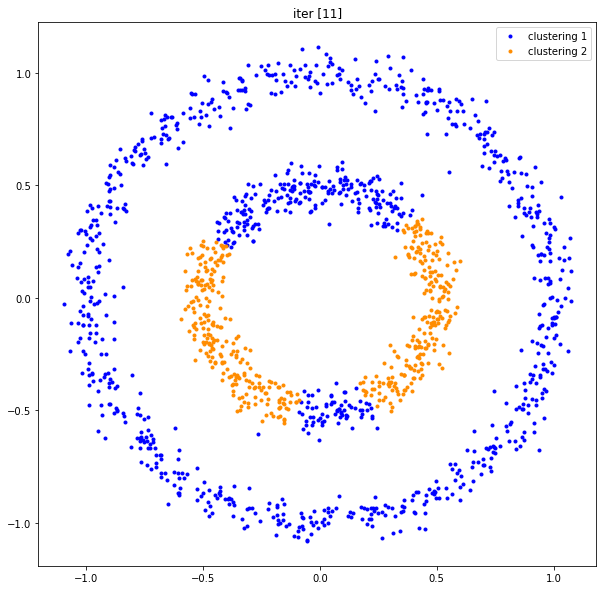

'use 11 counts to converge'

In [208]:
iter_count = 0
for new_c, new_u in launcher:
    IDisplay.clear_output(wait=True)
    iter_count += 1
    showClustering(data_source, new_c, new_u, title='iter [{}]'.format(iter_count))

'use {} counts to converge'.format(iter_count)

# spectral clustering

- Graph Laplacian

$$ L = D - W \\
D_{v,u} = d_v\delta_{vu}, d_v = \sum_{u \in V}W_{vu},  \delta_{vu} = \begin{cases} 1, & u = v \\ 0, & u \neq v \end{cases} \\
W_{v,u} = kernel(v,u)$$

- Unnormalized

$$ L $$

- Normalized

$$ D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}} $$

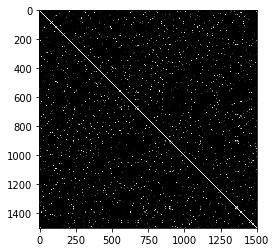

In [210]:
# initial setting
data_source = np.array(moon)
kernel = RBFkernel(100)
k = 2
similarity_matrix = kernel(data_source, data_source)
showGram(similarity_matrix)

In [211]:
# graph laplacian
W = similarity_matrix
D = np.sum(similarity_matrix, axis=1)*np.eye(similarity_matrix.shape[0])

L = D - W
L.shape

(1500, 1500)

In [212]:
%%time

eigen_values, eigen_vectors = np.linalg.eig(L)

CPU times: user 30.3 s, sys: 22 s, total: 52.3 s
Wall time: 7.25 s


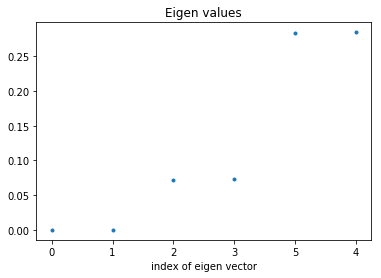

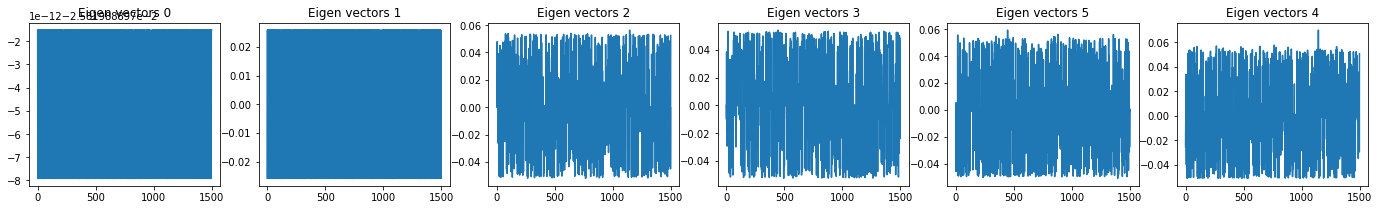

In [213]:
sorted_idx = np.argsort(eigen_values)

show_number = 6

plt.plot(eigen_values[sorted_idx[:show_number]],'.')
plt.xticks(range(show_number), sorted_idx[:show_number])
plt.title('Eigen values')
plt.xlabel('index of eigen vector')
plt.show()

plt.figure(figsize=(4*show_number,3))

for i in range(show_number):
    plt.subplot(1, show_number, i+1)
    plt.plot(eigen_vectors[:,sorted_idx[i]])
    plt.title('Eigen vectors '+str(sorted_idx[i]))

plt.show()

In [214]:
# generate new vector space to present origin data
# if eigen vector is fully connect , we need to drop it and use next one

sorted_idx = np.argsort(eigen_values)

U = []
use_eigen_idx = []
current_i = 0
current_k = 0

while current_k < k:
    evc = eigen_vectors[:,sorted_idx[current_i]]
    if True:
    #if (np.var(evc) > 10**-20):
        U.append(evc[:,None])
        use_eigen_idx.append(sorted_idx[current_i])
        current_k += 1
        
    current_i += 1

U = np.concatenate(U, axis=1)

U.shape, use_eigen_idx

((1500, 2), [0, 1])

In [98]:
import plotly
print(plotly.__version__)

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import figure_factory as ff
import plotly.plotly as py
init_notebook_mode(connected=True)

3.4.2


In [174]:
gogodata = [go.Scatter(x=U[:,0],
                       y=U[:,1],
                       mode='markers',
                       text=[str(i) in range(U.shape[0])],
                       name='represent data') 
            ]
#iplot(go.Figure(data=gogodata,layout=go.Layout(title='spectral clustering')))

In [215]:
#u = np.matmul(U.T, data_source)
#c = GetCluster(np.abs(U))

launcher = kmeans(U, 2)
#launcher = kmeans(similarity_matrix, k, initial_c=c, isKernel=True)

# showClustering(data_source, c, u)

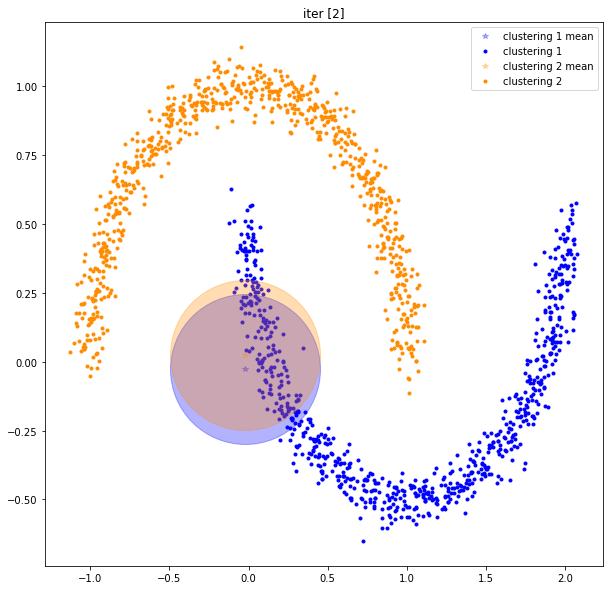

use 2 counts to converge


In [216]:
all_c, all_u = runKmeans(launcher)
#next(launcher)

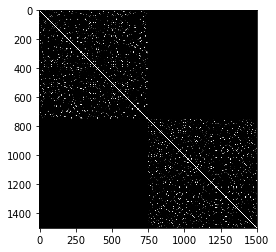

In [217]:
showGram(ReorderGram(W, all_c[-1]))

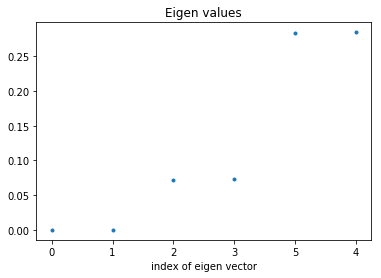

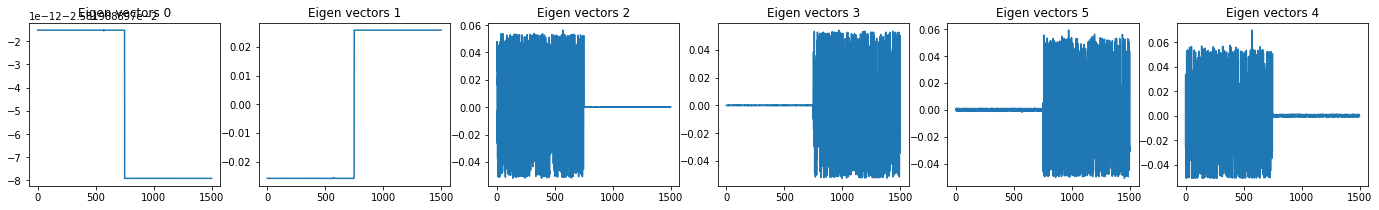

In [218]:
#showClustering(U, all_c[-1], all_u[-1])

# reorder to show eigen vector
sorted_idx = np.argsort(eigen_values)
reorder_data_idx = ReorderByCluster(all_c[-1])

show_number = 6

plt.plot(eigen_values[sorted_idx[:show_number]],'.')
plt.xticks(range(show_number), sorted_idx[:show_number])
plt.title('Eigen values')
plt.xlabel('index of eigen vector')
plt.show()

plt.figure(figsize=(4*show_number,3))

for i in range(show_number):
    plt.subplot(1, show_number, i+1)
    plt.plot(eigen_vectors[reorder_data_idx,sorted_idx[i]])
    plt.title('Eigen vectors '+str(sorted_idx[i]))

plt.show()

# 我是分隔線

In [1013]:
# initial setting
k = 2
data_source = np.array(circle)

# initial parameters
data_len = data_source.shape[0]
x_dims = data_source.shape[1]
u = [[random.random() for _ in range(x_dims)] for _ in range(k)]
#u = [[0.0 for _ in range(x_dims)] for _ in range(k)]
u = np.array(u)

#u = np.array([[0.01,-0.01],[-0.01,0.01]])
u

In [698]:
# E-step
# w = len(data)*k
# c = len(data)*k (1 mean belong to this clustering)

w = np.matmul(data_source**2, np.ones((x_dims, k))) \
    + np.matmul(np.ones((data_len,x_dims)), (u**2).T) \
    - 2*np.dot(data_source, u.T)
#showClustering(data_source, c, u)

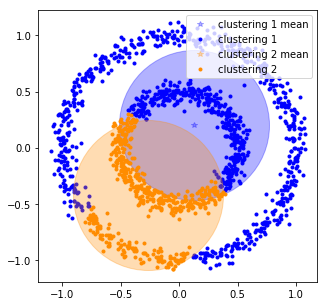

In [1075]:
# M-step
# update u = k*x_dims

c = np.zeros(w.shape)
c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1

u_update = np.matmul(c.T, data_source) / np.sum(c, axis=0)[:,None]

#showClustering(data_source, c, u)

u = u_update

showClustering(data_source, c, u_update)

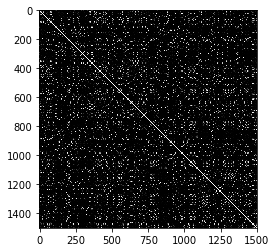

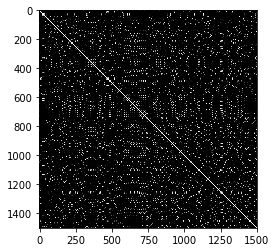

In [885]:
# initial setting
kernel = RBFkernel(13.66)
data_source = np.array(circle)
k = 2

# initial parameters
gram_matrix = kernel(data_source, data_source)
c = np.zeros((data_source.shape[0],k))
c[np.arange(c.shape[0]),np.random.randint(k,size=c.shape[0])] = 1

plt.imshow(gram_matrix, cmap='gray')
plt.show()
plt.imshow(ReorderGram(gram_matrix,c), cmap='gray')
plt.show()

In [962]:
# E-step

w = np.matmul(
        gram_matrix * np.eye(data_source.shape[0]), 
        np.ones((data_source.shape[0], c.shape[1])) 
    ) \
    - 2*( np.matmul(gram_matrix, c) / np.sum(c, axis=0) ) \
    + (np.matmul(
        np.ones((data_source.shape[0], c.shape[1])), 
        np.matmul(np.matmul(c.T, gram_matrix), c)*np.eye(c.shape[1])
    ) / (np.sum(c,axis=0)**2) )
w = w**2

0


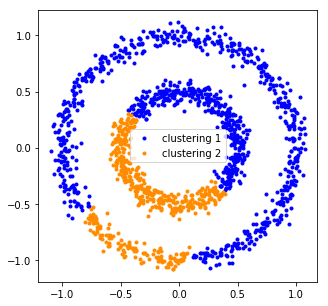

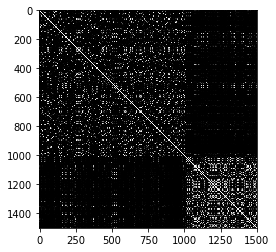

In [963]:
# M-step

update_c = np.zeros(w.shape)
update_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1

delta_c = np.count_nonzero(np.abs(update_c - c))

c = update_c

print(delta_c)

showClustering(data_source, update_c)
plt.imshow(ReorderGram(gram_matrix,c), cmap='gray')
plt.show()

In [1280]:
X_norm = np.einsum('ij,ij->i',data_source[:10], data_source[:10])
X_norm

array([0.36376516, 0.87837047, 0.95950904, 0.94601545, 0.02444423,
       0.93978325, 1.15547339, 0.65468313, 1.23598163, 0.88360984])

In [16]:
from scipy.linalg.blas import sgemm
import numexpr as ne
from sklearn.metrics.pairwise import rbf_kernel

def app1(u, v, gamma, var):
    u_norm = np.sum(u ** 2, axis = -1)
    v_norm = np.sum(v ** 2, axis = -1)
    return var * np.exp(-gamma * (u_norm[:,None] + v_norm[None,:] - 2 * np.dot(u, v.T)))
    
def app0(u,v, gamma, var):
    return var*RBFkernel(gamma)(u,v)

def app2(u,v, gamma, var):
    return var*rbf_kernel(u,v,gamma=gamma)

In [17]:
test = np.array(circle)[:10]
test.shape

(10, 2)

In [18]:
%timeit app0(test,test,1.0,1)
%timeit app1(test,test,1.0,1)
%timeit app2(test,test,1.0,1)

53.5 µs ± 2.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
60.4 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
152 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
np.allclose(app0(test,test,1.0,1), app1(test,test,1.0,1)),np.allclose(app0(test,test,1.0,1), app2(test,test,1.0,1))

(True, True)